In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

In [2]:
df_orig = pd.read_csv('MotoGP_2002_2018.csv', index_col=0, parse_dates=['Date'])

In [3]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24141 entries, 0 to 24140
Data columns (total 29 columns):
Year                          24141 non-null int64
TRK                           24141 non-null object
Track                         24141 non-null object
Category                      24141 non-null object
Session                       24141 non-null object
Date                          24136 non-null datetime64[ns]
Track_Condition               20883 non-null object
Track_Temp                    20883 non-null float64
Air_Temp                      20883 non-null float64
Humidity                      20883 non-null float64
Position                      24136 non-null object
Points                        24136 non-null float64
Rider_Number                  20883 non-null float64
Rider_Name                    24136 non-null object
Nationality                   24136 non-null object
Team_Name                     20883 non-null object
Bike                          24136 non-null ob

In [4]:
df = df_orig.copy(deep=True)

In [5]:
# convert finish time into a numerical since it'll be the target of our regression
df['Finish_Time'] = df['Finish_Time'].map(lambda x: pd.to_timedelta(x))
df['Finish_Time_ms'] = df['Finish_Time'].map(lambda x: x/pd.to_timedelta(1, unit='ms'))

# add up left and right corners
df['corners'] = df['Left_Corners'] + df['Right_Corners']

# drop N/A values
df.dropna(axis = 0, inplace=True)

In [6]:

# examine the top 20 riders
(df
 .groupby(['Rider_Name'])['Points']
 .mean().reset_index()
 .sort_values(by='Points', ascending=False)
).head(20)

,Rider_Name,Points
66,Can ONCU,25.000000
86,Daniel PEDROSA,22.555556
282,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
206,Jorge LORENZO,17.375000
439,Valentino ROSSI,16.077419
82,Dani PEDROSA,15.985507
300,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
191,Joan MIR,13.472222


In [7]:

df.replace(to_replace='Daniel PEDROSA', value='Dani PEDROSA', inplace=True)
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
66,Can ONCU,25.000000
281,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
205,Jorge LORENZO,17.375000
82,Dani PEDROSA,16.387755
438,Valentino ROSSI,16.077419
299,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
190,Joan MIR,13.472222
33,Andrea DOVIZIOSO,13.006623


In [8]:
df.groupby('Rider_Name').count()

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
Rider_Name,,,,,,,,,,,,,,,,,,,,,
Aaron POLANCO,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Adam NORRODIN,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Adrian MARTIN,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
Ai OGURA,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Aitor RODRIGUEZ,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Alan TECHER,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
Albert ARENAS,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
Alberto MONCAYO,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
Aleix ESPARGARO,124,124,124,124,124,124,124,124,124,124,...,124,124,124,124,124,124,124,124,124,124


In [9]:
threshold = 2000000
df[(df.Finish_Time_ms <= threshold)].sample(5)

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
2771,2017,ARA,ARA - MotorLand Aragón,Moto3,RAC,2017-09-24,Dry,30.0,22.0,66.0,...,10.0,7.0,15.0,968.0,167.0,116.8,106.6,96.5,1558905.0,17.0
3753,2016,NED,NED - TT Circuit Assen,MotoGP,RAC,2016-06-26,Wet,20.0,17.0,88.0,...,6.0,12.0,14.0,487.0,173.1,118.1,109.0,99.9,1590655.0,18.0
1476,2018,VAL,VAL - Circuit Ricardo Tormo,MotoGP,RAC2,2018-11-18,Wet,13.0,13.0,98.0,...,9.0,5.0,12.0,876.0,139.8,108.1,100.1,92.1,1476214.0,14.0
13179,2010,GER,GER - Sachsenring,MotoGP,RAC,2010-07-18,Dry,29.0,20.0,44.0,...,10.0,3.0,12.0,700.0,160.6,110.1,102.8,99.1,760222.0,13.0
13191,2010,GER,GER - Sachsenring,MotoGP,RAC2,2010-07-18,Dry,31.0,21.0,44.0,...,10.0,3.0,12.0,700.0,160.6,110.1,102.8,99.1,1765693.0,13.0


In [10]:
df_c = df.drop(axis=1, columns=['TRK', 'Track', 'Session', 'Date', 'Position', 'Rider_Name',
                                'Rider_Number', 'Nationality', 'Team_Name', 'Time', 'Finish_Time',
                                'Category', 'Left_Corners', 'Right_Corners', 'Avg_Speed'])

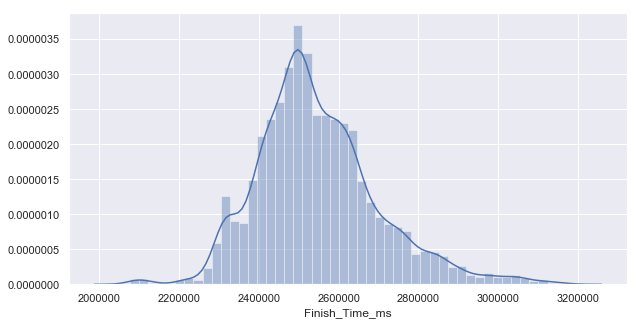

In [11]:
df = df[df.Finish_Time_ms >= threshold]
plt.figure(figsize=(10,5))
sns.distplot(df.Finish_Time_ms);

In [12]:
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
63,Can ONCU,25.000000
271,Marc MARQUEZ,19.450450
66,Casey STONER,17.820896
199,Jorge LORENZO,17.678832
79,Dani PEDROSA,16.435714
422,Valentino ROSSI,16.229730
289,Maverick VIÑALES,13.644444
184,Joan MIR,13.343750
31,Andrea DOVIZIOSO,12.875862
22,Alex RINS,12.857143


In [13]:
df_merged = df.merge(df_rider_mean)
df_model_prepped = df_merged[["Bike","length of longest straight","Right_Corners","Left_Corners", "Year", "track_width", "MotoGP_avg_speed", "GP_distance", "corners","Rider_Name","points_mean", "Track_Condition", "Track_Temp", "Humidity", "Track","Finish_Time_ms", "Category"]]
df_model_prepped["Rider_Name"] = df_model_prepped["Rider_Name"].apply(lambda x: x.lower())
df_model_prepped["Bike"] = df_model_prepped["Bike"].apply(lambda x: x.lower())
df_model_prepped["Track_Condition"] = df_model_prepped["Track_Condition"].apply(lambda x: x.lower())
df_model_prepped["Track"] = df_model_prepped["Track"].apply(lambda x: x.lower())

#df_model_prepped["Finish_Time_ms"] = round((df_model_prepped["Finish_Time_ms"]/60000),2)

C:\Users\Rconw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rconw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Rconw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a co

In [14]:
df_merged_encoded = df_model_prepped.copy()
df_merged_encoded.head()

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Track_Condition,Track_Temp,Humidity,Track,Finish_Time_ms,Category
0,ducati,1068.0,10.0,6.0,2018,12.0,166.6,118.4,16.0,andrea dovizioso,12.875862,dry,23.0,46.0,qat - losail international circuit,2554654.0,MotoGP
1,ducati,1076.0,9.0,5.0,2018,16.0,172.7,120.2,14.0,andrea dovizioso,12.875862,wet,23.0,94.0,arg - termas de río hondo,2458875.0,MotoGP
2,ducati,1200.0,9.0,11.0,2018,15.0,158.4,110.3,20.0,andrea dovizioso,12.875862,dry,35.0,45.0,ame - circuit of the americas,2525572.0,MotoGP
3,ducati,487.0,12.0,6.0,2018,14.0,173.1,118.1,18.0,andrea dovizioso,12.875862,dry,40.0,32.0,ned - tt circuit assen,2476285.0,MotoGP
4,ducati,700.0,3.0,10.0,2018,12.0,160.6,110.1,13.0,andrea dovizioso,12.875862,dry,48.0,48.0,ger - sachsenring,2472960.0,MotoGP


In [15]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl2 = LabelEncoder()
lbl3 = LabelEncoder()
lbl4 = LabelEncoder()

In [16]:
# Encoding string based columns
df_merged_encoded["Rider_Name"] = lbl.fit_transform(df_merged_encoded["Rider_Name"])
df_merged_encoded["Bike"] = lbl2.fit_transform(df_merged_encoded["Bike"])
df_merged_encoded["Track_Condition"] = lbl3.fit_transform(df_merged_encoded["Track_Condition"])
df_merged_encoded["Track"] = lbl4.fit_transform(df_merged_encoded["Track"])
#df_merged_encoded.to_csv("model_encoded_data.csv")

In [17]:
df_merged_encoded = df_merged_encoded[df_merged_encoded.Category == "MotoGP"]
df_merged_encoded.head()

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Track_Condition,Track_Temp,Humidity,Track,Finish_Time_ms,Category
0,12,1068.0,10.0,6.0,2018,12.0,166.6,118.4,16.0,31,12.875862,0,23.0,46.0,10,2554654.0,MotoGP
1,12,1076.0,9.0,5.0,2018,16.0,172.7,120.2,14.0,31,12.875862,1,23.0,94.0,2,2458875.0,MotoGP
2,12,1200.0,9.0,11.0,2018,15.0,158.4,110.3,20.0,31,12.875862,0,35.0,45.0,0,2525572.0,MotoGP
3,12,487.0,12.0,6.0,2018,14.0,173.1,118.1,18.0,31,12.875862,0,40.0,32.0,9,2476285.0,MotoGP
4,12,700.0,3.0,10.0,2018,12.0,160.6,110.1,13.0,31,12.875862,0,48.0,48.0,6,2472960.0,MotoGP


In [18]:
df_merged_encoded = df_merged_encoded.drop(columns=['Category'])

In [19]:
df_merged_encoded.head()

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Track_Condition,Track_Temp,Humidity,Track,Finish_Time_ms
0,12,1068.0,10.0,6.0,2018,12.0,166.6,118.4,16.0,31,12.875862,0,23.0,46.0,10,2554654.0
1,12,1076.0,9.0,5.0,2018,16.0,172.7,120.2,14.0,31,12.875862,1,23.0,94.0,2,2458875.0
2,12,1200.0,9.0,11.0,2018,15.0,158.4,110.3,20.0,31,12.875862,0,35.0,45.0,0,2525572.0
3,12,487.0,12.0,6.0,2018,14.0,173.1,118.1,18.0,31,12.875862,0,40.0,32.0,9,2476285.0
4,12,700.0,3.0,10.0,2018,12.0,160.6,110.1,13.0,31,12.875862,0,48.0,48.0,6,2472960.0


In [20]:
df_merged_encoded.to_csv("model_encoded_data.csv")

In [21]:
import operator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

df_training = pd.read_csv('model_encoded_data.csv', index_col=0)

x = df_training.drop("Finish_Time_ms", axis = 1)
y = df_training["Finish_Time_ms"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x_train)

model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
r2 = r2_score(y_train,y_poly_pred)
print(rmse)
print(r2)

23652.669969006325
0.9732878293621662


In [22]:
x_poly_test = polynomial_features.fit_transform(x_test)
y_poly_pred = model.predict(x_poly_test)

rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print(rmse)
print(r2)

28720.30842122734
0.9602122239125654


In [23]:
# df_training = pd.read_csv('test_csv.csv')

# df_training["rider_mean"] = 12.598361
# df_training["Finish_Time_ms"] =""

# df_training["Rider_Name"] = lbl.fit_transform(df_training ["Rider_Name"])
# df_training["Bike"] = lbl2.fit_transform(df_training ["Bike"])
# df_training["Track_Condition"] = lbl3.fit_transform(df_training ["Track_Condition"])
# df_training["Track"] = lbl4.fit_transform(df_training ["Track"])
# df_training["points_mean"] = 12.598361

# x = df_training.drop("Finish_Time_ms", axis = 1)
# y = df_training["Finish_Time_ms"]

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

# polynomial_features= PolynomialFeatures(degree=3)
# x_poly = polynomial_features.fit_transform(x_train)
# x_poly_test = polynomial_features.fit_transform(x_test)

# y_poly_pred = model.predict(x_poly_test)
# y_poly_pred

In [24]:
# df_predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_poly_pred})
# df_predictions["Predicted"] = round(df_predictions["Predicted"],2)
# df_predictions

In [25]:
df_2019 = pd.read_csv('MotoGP_2019.csv', index_col=0, parse_dates=['Date'])

In [26]:
# convert finish time into a numerical since it'll be the target of our regression
df_2019['Finish_Time'] = df_2019['Finish_Time'].map(lambda x: pd.to_timedelta(x))
df_2019['Finish_Time_ms'] = df_2019['Finish_Time'].map(lambda x: x/pd.to_timedelta(1, unit='ms'))

# add up left and right corners
df_2019['corners'] = df_2019['Left_Corners'] + df_2019['Right_Corners']

# Use only the motoGP category
df_2019 = df_2019[df_2019.Category == "MotoGP"]

#drop finish outlirer finish times 
df_2019 = df_2019[df_2019.Finish_Time_ms >= threshold]

# drop N/A values
df_2019.dropna(axis = 0, inplace=True)

In [27]:
df_2019.head()

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
0,2019,QAT,QAT - Losail International Circuit,MotoGP,RAC,2019-03-10,Dry,19,18,52,...,6,10,12,1068,166.6,118.4,107.6,96.8,2556902.0,16
1,2019,QAT,QAT - Losail International Circuit,MotoGP,RAC,2019-03-10,Dry,19,18,52,...,6,10,12,1068,166.6,118.4,107.6,96.8,2556925.0,16
2,2019,QAT,QAT - Losail International Circuit,MotoGP,RAC,2019-03-10,Dry,19,18,52,...,6,10,12,1068,166.6,118.4,107.6,96.8,2557222.0,16
3,2019,QAT,QAT - Losail International Circuit,MotoGP,RAC,2019-03-10,Dry,19,18,52,...,6,10,12,1068,166.6,118.4,107.6,96.8,2557359.0,16
4,2019,QAT,QAT - Losail International Circuit,MotoGP,RAC,2019-03-10,Dry,19,18,52,...,6,10,12,1068,166.6,118.4,107.6,96.8,2557502.0,16


In [28]:
df_2019 = df_2019[["Bike","length of longest straight","Right_Corners","Left_Corners", "Year", "track_width", "MotoGP_avg_speed", "GP_distance", "corners","Rider_Name","points_mean", "Track_Condition", "Track_Temp", "Humidity", "Track","Finish_Time_ms"]]
df_2019["Rider_Name"] = df_2019["Rider_Name"].apply(lambda x: x.lower())
df_2019["Bike"] = df_2019["Bike"].apply(lambda x: x.lower())
df_2019["Track_Condition"] = df_2019["Track_Condition"].apply(lambda x: x.lower())
df_2019["Track"] = df_2019["Track"].apply(lambda x: x.lower())

QAT = ("qat - losail international circuit")
df_2019 = df_2019[(df_2019.Track == QAT)]


# df_2019["Finish_Time_ms"] = round((df_2019["Finish_Time_ms"]/60000),5)
# df_2019.rename(columns={'Finish_Time_ms':'Finish_Time_mins'}, inplace=True)


df_2019.head(35)

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Track_Condition,Track_Temp,Humidity,Track,Finish_Time_ms
0,ducati,1068,10,6,2019,12,166.6,118.4,16,andrea dovizioso,12.598361,dry,19,52,qat - losail international circuit,2556902.0
1,honda,1068,10,6,2019,12,166.6,118.4,16,marc marquez,20.052632,dry,19,52,qat - losail international circuit,2556925.0
2,honda,1068,10,6,2019,12,166.6,118.4,16,cal crutchlow,10.273973,dry,19,52,qat - losail international circuit,2557222.0
3,suzuki,1068,10,6,2019,12,166.6,118.4,16,alex rins,11.647059,dry,19,52,qat - losail international circuit,2557359.0
4,yamaha,1068,10,6,2019,12,166.6,118.4,16,valentino rossi,16.077419,dry,19,52,qat - losail international circuit,2557502.0
5,ducati,1068,10,6,2019,12,166.6,118.4,16,danilo petrucci,6.276923,dry,19,52,qat - losail international circuit,2559222.0
6,yamaha,1068,10,6,2019,12,166.6,118.4,16,maverick viñales,10.320000,dry,19,52,qat - losail international circuit,2559383.0
7,suzuki,1068,10,6,2019,12,166.6,118.4,16,joan mir,0.000000,dry,19,52,qat - losail international circuit,2561990.0
8,honda,1068,10,6,2019,12,166.6,118.4,16,takaaki nakagami,3.076923,dry,19,52,qat - losail international circuit,2564308.0
9,aprilia,1068,10,6,2019,12,166.6,118.4,16,aleix espargaro,6.530864,dry,19,52,qat - losail international circuit,2566538.0


In [29]:
df_2019["Rider_Name"] = lbl.transform(df_2019["Rider_Name"])
df_2019["Bike"] = lbl2.transform(df_2019["Bike"])
df_2019["Track_Condition"] = lbl3.transform(df_2019["Track_Condition"])
df_2019["Track"] = lbl4.transform(df_2019["Track"])

In [30]:
df_real = df_2019.copy()
df_real.head()

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Track_Condition,Track_Temp,Humidity,Track,Finish_Time_ms
0,12,1068,10,6,2019,12,166.6,118.4,16,31,12.598361,0,19,52,10,2556902.0
1,24,1068,10,6,2019,12,166.6,118.4,16,270,20.052632,0,19,52,10,2556925.0
2,24,1068,10,6,2019,12,166.6,118.4,16,61,10.273973,0,19,52,10,2557222.0
3,60,1068,10,6,2019,12,166.6,118.4,16,22,11.647059,0,19,52,10,2557359.0
4,68,1068,10,6,2019,12,166.6,118.4,16,421,16.077419,0,19,52,10,2557502.0


In [31]:
# df_real["Position"] = df_real["Position"].astype(int)
# df_real.dtypes

In [32]:
x2 = df_real.drop("Finish_Time_ms", axis = 1)
y2 = df_real["Finish_Time_ms"]

polynomial_features= PolynomialFeatures(degree=3)

x_poly_test = polynomial_features.fit_transform(x2)

y_poly_pred = model.predict(x_poly_test)



In [33]:
df_2019['Rider_Name'] = lbl.inverse_transform(df_2019['Rider_Name'])

df_predictions2 = pd.DataFrame({'Actual': y2, 'Predicted': y_poly_pred})
df_predictions2['Predicted'] = df_predictions2['Predicted']
#df_predictions2['Predicted'] = round(df_predictions2['Predicted'],5)

df_predictions2['Rank'] = df_predictions2['Predicted'].rank()
df_predictions2.round({'Rank': 0})
df_predictions2=df_predictions2.sort_values(by=['Rank'])
df_predictions2['Rider_Name'] = df_2019['Rider_Name']

df_predictions2

,Actual,Predicted,Rank,Rider_Name
1,2556925.0,2.545305e+06,1.0,marc marquez
3,2557359.0,2.545350e+06,2.0,alex rins
4,2557502.0,2.551006e+06,3.0,valentino rossi
0,2556902.0,2.551999e+06,4.0,andrea dovizioso
6,2559383.0,2.558886e+06,5.0,maverick viñales
2,2557222.0,2.560563e+06,6.0,cal crutchlow
12,2571209.0,2.562157e+06,7.0,jorge lorenzo
10,2566549.0,2.563156e+06,8.0,franco morbidelli
9,2566538.0,2.565797e+06,9.0,aleix espargaro
5,2559222.0,2.571283e+06,10.0,danilo petrucci


In [34]:
print(list(zip(model.coef_)))

[(-15.836558451998965,), (1692828.540019082,), (2171327.1036774074,), (1826620.627829071,), (-160206.4063045699,), (646459.1443640069,), (158327.84570484486,), (-2104083.2291441173,), (-3037013.3616969814,), (-276953.2251676501,), (-1909081.4341744024,), (-89472.76540172081,), (-249197.8683051332,), (-161722.57238433833,), (110493.72555661948,), (394256.34595185594,), (1765.9480139718207,), (-253832.9085904589,), (-57577.03962482189,), (-34872.92785044628,), (8646.257216468275,), (-37509.56222418855,), (-5552.437726365092,), (220467.81463681516,), (5238.2524859589485,), (90.17233487522333,), (-1204.5696191912152,), (-205782.50040636724,), (-3415.238267410012,), (1731.4202311804524,), (4223.33884165536,), (6080100.269408226,), (51564.79861242856,), (58560.02826375469,), (-894361.495277841,), (54993.99459302095,), (676246.0303508209,), (325128.5039231706,), (98572.69143692858,), (133549.9292618128,), (107057.83552953467,), (-2076.778936825661,), (110518.76620343016,), (74067.0251944916,)